In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [8]:
# Installing packages
!pip install duckdb
!pip install watermark
!pip install pysmiles
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 50.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 36.9 MB/s eta 0:00:00:00:0100:01


In [9]:
import duckdb

In [10]:
## Import packages here
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [11]:
# Database - Parquet format
data_train = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

# Bank connection
con = duckdb.connect()

# Query
data = con.query(f"""(SELECT * FROM parquet_scan('{data_train}') 
WHERE binds = 0
ORDER BY random()
LIMIT 1000000)
UNION ALL
(SELECT * FROM parquet_scan('{data_train}')
WHERE binds = 1
ORDER BY random()
LIMIT 100000)""").df()

# Closing database
con.close()

# Saving dataset
data.to_csv("/kaggle/working/dataset.csv")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
# Viewing first 5 data
data.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,102154643,O=C(N[C@@H](Cc1ccc([N+](=O)[O-])cc1)C(=O)O)OCC...,NCc1cnn(Cc2ccccc2)c1,CS(=O)C1(CN)CCC1,CS(=O)C1(CNc2nc(NCc3cnn(Cc4ccccc4)c3)nc(N[C@@H...,sEH,0
1,290963871,O=C(O)[C@H]1COCCN1C(=O)OCC1c2ccccc2-c2ccccc21,CC1(C)OB(c2ccc(N)cc2)OC1(C)C,Cc1ccnc(N)c1,Cc1ccnc(Nc2nc(Nc3ccc(B4OC(C)(C)C(C)(C)O4)cc3)n...,BRD4,0
2,228771785,O=C(Nc1nc2ncc(CNc3ccc(C(=O)O)cc3)nc2c(=O)[nH]1...,Nc1ncccc1F,CC(CN)Cn1cccn1,CC(CNc1nc(Nc2nc3ncc(CNc4ccc(C(=O)N[Dy])cc4)nc3...,sEH,0
3,197196208,O=C(Nc1ccc(Cl)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,C#CCOc1cccc(CN)c1.Cl,COC(=O)c1cc(Cl)nc(Cl)c1N,C#CCOc1cccc(CNc2nc(Nc3ccc(Cl)c(C(=O)N[Dy])c3)n...,HSA,0
4,151803216,O=C(Nc1c(F)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1cc(N)n(-c2ccccc2)n1,Cc1conc1CN,Cc1cc(Nc2nc(NCc3nocc3C)nc(Nc3c(F)cccc3C(=O)N[D...,BRD4,0


In [13]:
# Viewing 5 latest data
data.tail()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
1099995,51630341,Cc1cc(C)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)...,Cc1cnc(N)cn1,CCOC(=O)c1ncccc1N,CCOC(=O)c1ncccc1Nc1nc(Nc2cnc(C)cn2)nc(Nc2c(C)c...,sEH,1
1099996,157820775,O=C(Nc1cc(Br)c(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccc...,Nc1ccc([N+](=O)[O-])c(Br)c1,CCOC(=O)c1nonc1N,CCOC(=O)c1nonc1Nc1nc(Nc2ccc([N+](=O)[O-])c(Br)...,BRD4,1
1099997,83084927,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,COc1cnc(CN)cn1.Cl.Cl,Nc1cc[nH]n1,COc1cnc(CNc2nc(NC[C@H]3CC[C@H](C(=O)N[Dy])CC3)...,sEH,1
1099998,292808163,O=C(O)[C@H]1C[C@H](O)CN1C(=O)OCC1c2ccccc2-c2cc...,NCc1cccnc1N1CCC(C(N)=O)CC1,Nc1ccc2ncoc2c1,NC(=O)C1CCN(c2ncccc2CNc2nc(Nc3ccc4ncoc4c3)nc(N...,BRD4,1
1099999,109491283,O=C(N[C@@H](Cc1cscn1)C(=O)O)OCC1c2ccccc2-c2ccc...,Cl.NCC(F)(F)CC1CC1,Nc1nc(Cl)c(C=O)c(Cl)n1,O=Cc1c(Cl)nc(Nc2nc(NCC(F)(F)CC3CC3)nc(N[C@@H](...,HSA,1


In [14]:
# Rows and columns
data.shape

(1100000, 7)

In [15]:
# Info data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   id                     1100000 non-null  int64 
 1   buildingblock1_smiles  1100000 non-null  object
 2   buildingblock2_smiles  1100000 non-null  object
 3   buildingblock3_smiles  1100000 non-null  object
 4   molecule_smiles        1100000 non-null  object
 5   protein_name           1100000 non-null  object
 6   binds                  1100000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 58.7+ MB


In [16]:
data.dtypes

id                        int64
buildingblock1_smiles    object
buildingblock2_smiles    object
buildingblock3_smiles    object
molecule_smiles          object
protein_name             object
binds                     int64
dtype: object

In [17]:
data.columns

Index(['id', 'buildingblock1_smiles', 'buildingblock2_smiles',
       'buildingblock3_smiles', 'molecule_smiles', 'protein_name', 'binds'],
      dtype='object')

In [18]:
print(data.buildingblock1_smiles.nunique())
data.buildingblock1_smiles.value_counts()


271


buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21                  19276
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21          13524
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                     5834
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O              5638
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21                  5607
                                                               ...  
O=C(Nc1c(I)c(C(=O)O)c(I)c(C(=O)O)c1I)OCC1c2ccccc2-c2ccccc21     3636
O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21                    3626
O=C(Nc1nc(Cl)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21                  3615
O=C(CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O)OC1CCCCC1       3596
O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccccc21              3537
Name: count, Length: 271, dtype: int64

In [19]:
print(data.buildingblock2_smiles.nunique())
data.buildingblock2_smiles.value_counts()

693


buildingblock2_smiles
Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]    5471
Cl.Cl.NCc1cncc(F)c1                5377
Cl.NCc1cnc2n1CCOC2                 4231
NCCC1CSC1                          3919
Nc1ccc(Cn2ccnc2)cc1                3597
                                   ... 
Cl.NCc1ccsc1C(F)(F)F                526
COc1ccnc(N)c1                       522
Cl.Nc1ccc2cccnc2c1                  513
Cl.NCC1C=CCC1                       511
CN(Cc1ccco1)Cc1ccccc1CN             497
Name: count, Length: 693, dtype: int64

In [20]:
print(data.buildingblock3_smiles.nunique())
data.buildingblock3_smiles.value_counts()

872


buildingblock3_smiles
Cc1cc2cc(CN)ccc2[nH]1     5368
Cl.Cn1cc(N)ccc1=O         3791
Nc1ccc2c(c1)CNC2=O        2724
NCc1ccc(CN2CCCC2=O)cc1    2701
Nc1cncc(F)c1              2496
                          ... 
Cl.NCc1cnc2n1CCOC2          16
NCc1c(F)cccc1N1CCCC1        15
Nc1nc(-c2ccc(F)cc2)cs1      10
CC1(CCCCN)OCCO1              8
NCc1ccccn1                   1
Name: count, Length: 872, dtype: int64

In [21]:
data.molecule_smiles.value_counts()

molecule_smiles
Cc1conc1CNc1nc(NCc2cncn2C)nc(Nc2c(Cl)cccc2C(=O)N[Dy])n1                             3
O=C(CNc1nc(NCC2CCN(c3ccc(Br)cc3)C2)nc(NC2(C(=O)N[Dy])CCOCC2)n1)NCc1ccncc1           3
Cc1cc2cc(CNc3nc(NCc4cnc5n4CCOC5)nc(Nc4ccc(C(=O)N[Dy])cc4O)n3)ccc2[nH]1              3
O=C(N[Dy])C(CCc1ccccc1)Nc1nc(NC[C@@H]2CCO[C@H]2c2cn[nH]c2)nc(Nc2cncc(F)c2)n1        3
N#Cc1cncnc1Nc1nc(NCC(F)(F)C(N)=O)nc(N[C@@H](CC(=O)N[Dy])Cc2ccc(Cl)cc2Cl)n1          3
                                                                                   ..
CC(CNc1nc(Nc2ccnc(C(=O)N[Dy])c2)nc(Nc2ncccc2F)n1)c1nccs1                            1
C=CC[C@@H](Nc1nc(NCC(=O)NCCOC)nc(NCC(C)S(=O)(=O)N2CCN(c3ccccc3)CC2)n1)C(=O)N[Dy]    1
Cc1c(Br)cccc1Nc1nc(NCC2CSCCN2Cc2ccccc2)nc(N2Cc3ccccc3C[C@@H]2C(=O)N[Dy])n1          1
COc1ccc(Cl)c(Nc2nc(Nc3ccc(C(=O)N[Dy])c(F)c3)nc(Nc3ncccc3CO)n2)c1                    1
O=Cc1c(Cl)nc(Nc2nc(NCC(F)(F)CC3CC3)nc(N[C@@H](Cc3cscn3)C(=O)N[Dy])n2)nc1Cl          1
Name: count, Length: 1095549, dtype: i

In [22]:
# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

In [23]:
data.tail()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
1099995,265755512,O=C(O)C[C@H](Cc1ccc(Br)cc1)NC(=O)OCC1c2ccccc2-...,Nc1cnc(Br)cn1,Cl.NCC1(F)CCCCC1,O=C(C[C@H](Cc1ccc(Br)cc1)Nc1nc(NCC2(F)CCCCC2)n...,sEH,0
1099996,243422321,O=C(O)C[C@@H](Cc1ccc(Br)cc1)NC(=O)OCC1c2ccccc2...,Cl.Cl.NCCCN1CCNC(=O)C1,Cl.NCC1C=CCC1,O=C(C[C@@H](Cc1ccc(Br)cc1)Nc1nc(NCCCN2CCNC(=O)...,sEH,0
1099997,115000113,O=C(N[C@H](C(=O)O)c1ccsc1)OCC1c2ccccc2-c2ccccc21,Cl.NCCNC(=O)c1ccn[nH]1,CCS(=O)CCN.Cl,CCS(=O)CCNc1nc(NCCNC(=O)c2ccn[nH]2)nc(N[C@H](C...,BRD4,0
1099998,65913779,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...,Cl.NCC(=O)NCc1ccncc1,CSc1nnc(CN)s1,CSc1nnc(CNc2nc(NCC(=O)NCc3ccncc3)nc(N[C@@H](CC...,sEH,0
1099999,188234406,O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,Nc1cc(-c2cccc(Br)c2)no1,CSc1nnc(CN)s1,CSc1nnc(CNc2nc(Nc3ccc(C(=O)N[Dy])cc3)nc(Nc3cc(...,BRD4,1


In [24]:
data.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,186893793,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCCCCF,Cc1cccc(N)c1Cl,Cc1cccc(Nc2nc(NCCCCF)nc(Nc3ccc(C(=O)N[Dy])c([N...,BRD4,0
1,176051533,O=C(Nc1cc(F)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.NCc1ccc(-c2nnn[nH]2)cc1,NCC1CSCCN1Cc1ccccc1,O=C(N[Dy])c1ccc(F)cc1Nc1nc(NCc2ccc(-c3nnn[nH]3...,HSA,0
2,29319055,COc1c(F)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1cccc2cnccc12,Nc1nccc2cccnc12,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(Nc2cccc3cnccc23...,HSA,1
3,123276651,O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2...,COC(=O)c1cc(F)c(F)cc1N,Cl.Cn1cc(CN)c(=O)[nH]c1=O,COC(=O)c1cc(F)c(F)cc1Nc1nc(NCc2cn(C)c(=O)[nH]c...,BRD4,0
4,227365936,O=C(Nc1nc2ccc(C(=O)O)cc2s1)OCC1c2ccccc2-c2ccccc21,NCC1CCCCC(F)(F)C1,Nc1cc(Cl)nc(Cl)c1[N+](=O)[O-],O=C(N[Dy])c1ccc2nc(Nc3nc(NCC4CCCCC(F)(F)C4)nc(...,HSA,0


In [25]:
data_copy=data.copy()

In [26]:
data_copy.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,186893793,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCCCCF,Cc1cccc(N)c1Cl,Cc1cccc(Nc2nc(NCCCCF)nc(Nc3ccc(C(=O)N[Dy])c([N...,BRD4,0
1,176051533,O=C(Nc1cc(F)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.NCc1ccc(-c2nnn[nH]2)cc1,NCC1CSCCN1Cc1ccccc1,O=C(N[Dy])c1ccc(F)cc1Nc1nc(NCc2ccc(-c3nnn[nH]3...,HSA,0
2,29319055,COc1c(F)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1cccc2cnccc12,Nc1nccc2cccnc12,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(Nc2cccc3cnccc23...,HSA,1
3,123276651,O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2...,COC(=O)c1cc(F)c(F)cc1N,Cl.Cn1cc(CN)c(=O)[nH]c1=O,COC(=O)c1cc(F)c(F)cc1Nc1nc(NCc2cn(C)c(=O)[nH]c...,BRD4,0
4,227365936,O=C(Nc1nc2ccc(C(=O)O)cc2s1)OCC1c2ccccc2-c2ccccc21,NCC1CCCCC(F)(F)C1,Nc1cc(Cl)nc(Cl)c1[N+](=O)[O-],O=C(N[Dy])c1ccc2nc(Nc3nc(NCC4CCCCC(F)(F)C4)nc(...,HSA,0


<Axes: xlabel='binds'>

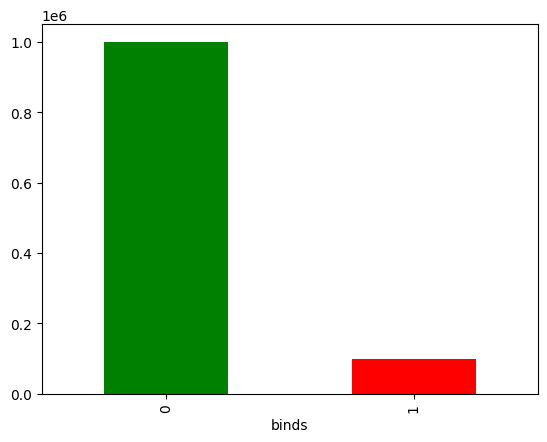

In [27]:
# Visualize the count for each class
data_copy['binds'].value_counts().plot.bar(color=['green', 'red'])

In [28]:
data_copy.isnull().sum()

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

In [29]:
# Assuming 'data' is your DataFrame
duplicate_counts = data_copy.apply(lambda x: x.duplicated().sum())
duplicate_counts


id                             0
buildingblock1_smiles    1099729
buildingblock2_smiles    1099307
buildingblock3_smiles    1099128
molecule_smiles             4451
protein_name             1099997
binds                    1099998
dtype: int64

In [30]:
# Get a Pd.Series consisting of all the string categoricals
#one_hot_encode_cols = data_copy.dtypes[data_copy.dtypes == 'object']  # filtering by string categoricals
#one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

#data_copy[one_hot_encode_cols].head().T

In [31]:
# Do the one hot encoding
#data_copy = pd.get_dummies(data_copy, columns=one_hot_encode_cols, drop_first=True)
#data_copy.shape

In [32]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit the encoder to the entire dataset (flattened)
le.fit(data_copy[['buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'protein_name', 'molecule_smiles']].values.reshape(-1, 1))

# Transform each column using the same encoder
data_copy['buildingblock1_smiles'] = le.transform(data_copy['buildingblock1_smiles'])
data_copy['buildingblock2_smiles'] = le.transform(data_copy['buildingblock2_smiles'])
data_copy['buildingblock3_smiles'] = le.transform(data_copy['buildingblock3_smiles'])
data_copy['protein_name'] = le.transform(data_copy['protein_name'])
data_copy['molecule_smiles'] = le.transform(data_copy['molecule_smiles'])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
data_copy.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,186893793,1075406,795620,719323,720233,0,0
1,176051533,1075396,795656,870662,1034237,829598,0
2,29319055,422490,870848,870926,422324,829598,1
3,123276651,923981,318843,795577,319872,0,0
4,227365936,1075990,870657,870760,1052106,829598,0


In [37]:
import seaborn as sns
#sns.pairplot(data_copy, plot_kws=dict(alpha=.1, edgecolor='none'))

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap(data_copy.corr(),annot=True,cmap='RdYlGn')

plt.show()

In [39]:
target= 'binds'
data_copy[target].value_counts(normalize=True)

binds
0    0.909091
1    0.090909
Name: proportion, dtype: float64

In [ ]:
rs=123
# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = { 
        'max_depth': [5, 10, 15, 20], 
        'n_estimators': [25, 50, 100], 
        'min_samples_split': [2, 5], 
        'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}] 
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, param_grid = params_grid, scoring='f1', cv = 5, verbose = 1)
    grid_search.fit(X_train.drop(['id'], axis=1), y_train)
    preds = preds = grid_search.predict(x_test.drop(['id'], axis=1))
    probs = grid_search.predict_proba(x_test.drop(['id'], axis=1))[:, 1]
    probs_df = pd.DataFrame({'ID': x_test['id'], 'PROBABILITY': probs, 'PREDICTION':preds})
    print(probs_df)

    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print('Confusion Matrix - Random Forest:\n', cm)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Random Forest')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve - Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    # Classification metrics report
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    print('Metrics - Random Forest:')
    print('F1 Score:', f1)
    print('Recall:', recall)
    print('Precision:', precision)
    print('Accuracy:', accuracy)

    # Feature importance
    feature_importances = grid_search.best_estimator_.feature_importances_
    feature_names = X_train.drop(['id'], axis=1).columns
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importances)
    plt.title('Feature Importances - Random Forest')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.show()
    

    

# Grid search hyperparameters for a XGBoost model
def grid_search_xgb(X_train, y_train):
    params_grid = {
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 50, 100],
        'learning_rate': [0.1, 0.5, 1],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
    xgb_model = XGBClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_grid, scoring='f1', cv=4, verbose=1)
    grid_search.fit(X_train.drop('id', axis=1), y_train)
    preds = grid_search.predict(x_test.drop('id', axis=1))
    probs = grid_search.predict_proba(x_test.drop(['id'], axis=1))[:, 1]
    probs_df = pd.DataFrame({'ID': x_test['id'], 'PROBABILITY': probs, 'PREDICTION':preds})
    print(probs_df)

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print('Confusion Matrix - XGBoost:\n', cm)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='XGBoost')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve - XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Feature importance
    feature_importances = grid_search.best_estimator_.feature_importances_
    feature_names = X_train.drop('id', axis=1).columns
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importances)
    plt.title('Feature Importances - XGBoost')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.show()

     # Classification metrics report
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    print('Metrics - XGBoost:')
    print('F1 Score:', f1)
    print('Recall:', recall)
    print('Precision:', precision)
    print('Accuracy:', accuracy)

In [41]:
def split_data(df):
    X = df.loc[ : , df.columns != 'binds']
    y = df['binds'].astype('int')
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state = rs)

In [42]:
# Split the training and testing dataset
x_train, x_test, y_train, y_test = split_data(data_copy)

In [ ]:
grid_search_rf(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
grid_search_xgb(x_train, y_train)